In [40]:
import pandas as pd 
import torch 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import numpy as np 

In [101]:
preds = pd.read_csv('/home/teddy/local/workflow_outputs/tkgdti/TargetomeKG_Complex2_DTI_preds_12_29_25.csv')
data = torch.load('/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_predictions/complex2/Data.pt')
targetome = pd.read_csv('~/local/data/targetome_extended-01-23-25.csv')

/tmp/ipykernel_31798/1581318923.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_prediction

In [102]:
inchi2idx = {k:i for i,k in enumerate(data.node_name_dict['drug'])}
gene2idx = {k:i for i,k in enumerate(data.node_name_dict['gene'])}
uni2gene = preds[['uniprot_id', 'gene_symbol']].set_index('uniprot_id').to_dict()['gene_symbol']

targetome = targetome[['inchi_key','uniprot_id', 'assay_type', 'assay_relation', 'assay_value']].drop_duplicates() 
targetome = targetome[lambda x: x.assay_relation == '=']
targetome = targetome.groupby(['inchi_key', 'uniprot_id']).agg({'assay_value': 'median'}).reset_index()
targetome = targetome.assign(gene_symbol = targetome.uniprot_id.map(uni2gene))
targetome = targetome.assign(drug = targetome.inchi_key.map(inchi2idx))
targetome = targetome.assign(protein = targetome.gene_symbol.map(gene2idx))
targetome = targetome[lambda x: x.drug.notna() & x.protein.notna() & x.assay_value.notna()]
targetome.head() 

,inchi_key,uniprot_id,assay_value,gene_symbol,drug,protein
58,AAAQFGUYHFJNHI-SFHVURJKSA-N,O60885,100.0000,BRD4,0.0,1532.0
218,AADCDMQTJNYOSS-LBPRGKRZSA-N,P14416,0.1085,DRD2,2.0,3936.0
219,AADCDMQTJNYOSS-LBPRGKRZSA-N,P21917,47.5250,DRD4,2.0,3938.0
220,AADCDMQTJNYOSS-LBPRGKRZSA-N,P35462,0.1220,DRD3,2.0,3937.0
609,AAKJLRGGTJKAMG-UHFFFAOYSA-N,O00444,1900.0000,PLK4,3.0,11385.0


In [103]:
preds = preds.merge(targetome, left_on=['inchikey', 'uniprot_id'], right_on=['inchi_key', 'uniprot_id'], how='left')
preds.head() 

,inhibitor,inchikey,gene_symbol_x,uniprot_id,fnr_est_mean,fpr_est_mean,tnr_est_mean,tpr_est_mean,score_mean,in_n_folds,inchi_key,assay_value,gene_symbol_y,drug,protein
0,Alvocidib,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CLK1,P49759,0.992502,5.850210e-08,1.0,0.007498,-9.269436,10,BIIVYFLTOXDAOV-YVEFUNNKSA-N,1950.0,CLK1,165.0,2731.0
1,R-406,NHHQJBCNYHBUSI-UHFFFAOYSA-N,MAP4K1,Q92918,0.981329,2.022602e-07,1.0,0.018671,-9.468569,10,NHHQJBCNYHBUSI-UHFFFAOYSA-N,1400.0,MAP4K1,1472.0,8023.0
2,Penfluridol,MDLAAYDRRZXJIF-UHFFFAOYSA-N,ADRA1A,P35348,0.977590,3.433028e-07,1.0,0.022410,-9.522200,10,NaN,NaN,NaN,NaN,NaN
3,Midostaurin,BMGQWWVMWDBQGC-IIFHNQTCSA-N,ROCK1,Q13464,0.976725,4.858120e-07,1.0,0.023275,-9.532401,10,BMGQWWVMWDBQGC-IIFHNQTCSA-N,7800.0,ROCK1,182.0,12742.0
4,Kw-2449,YYLKKYCXAOBSRM-JXMROGBWSA-N,STK3,Q13188,0.976508,2.954414e-07,1.0,0.023492,-9.571021,10,NaN,NaN,NaN,NaN,NaN


In [111]:
preds.sort_values(by='fnr_est_mean', ascending=False).head(15)[['inhibitor', 'gene_symbol_x', 'score_mean', 'assay_value']].style.hide()

inhibitor,gene_symbol_x,score_mean,assay_value
Alvocidib,CLK1,-9.269436,1950.000000
R-406,MAP4K1,-9.468569,1400.000000
Penfluridol,ADRA1A,-9.522200,nan
Midostaurin,ROCK1,-9.532401,7800.000000
Kw-2449,STK3,-9.571021,nan
R-406,MAP4K5,-9.573486,nan
Tozasertib,KDR,-9.555174,2000.000000
Midostaurin,ROCK2,-9.623819,2300.000000
Tozasertib,CSF1R,-9.601390,1800.000000
Crizotinib,FRK,-9.642769,2900.000000


In [105]:
(~preds.assay_value.isna()).mean()

np.float64(0.2678435218480985)

In [112]:
preds.shape[0]

9177

In [122]:
preds = preds.assign(pKd = -(np.log10(preds.assay_value)))

In [123]:
preds.head() 

,inhibitor,inchikey,gene_symbol_x,uniprot_id,fnr_est_mean,fpr_est_mean,tnr_est_mean,tpr_est_mean,score_mean,in_n_folds,inchi_key,assay_value,gene_symbol_y,drug,protein,pKd
0,Alvocidib,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CLK1,P49759,0.992502,5.850210e-08,1.0,0.007498,-9.269436,10,BIIVYFLTOXDAOV-YVEFUNNKSA-N,1950.0,CLK1,165.0,2731.0,-3.290035
1,R-406,NHHQJBCNYHBUSI-UHFFFAOYSA-N,MAP4K1,Q92918,0.981329,2.022602e-07,1.0,0.018671,-9.468569,10,NHHQJBCNYHBUSI-UHFFFAOYSA-N,1400.0,MAP4K1,1472.0,8023.0,-3.146128
2,Penfluridol,MDLAAYDRRZXJIF-UHFFFAOYSA-N,ADRA1A,P35348,0.977590,3.433028e-07,1.0,0.022410,-9.522200,10,NaN,NaN,NaN,NaN,NaN,NaN
3,Midostaurin,BMGQWWVMWDBQGC-IIFHNQTCSA-N,ROCK1,Q13464,0.976725,4.858120e-07,1.0,0.023275,-9.532401,10,BMGQWWVMWDBQGC-IIFHNQTCSA-N,7800.0,ROCK1,182.0,12742.0,-3.892095
4,Kw-2449,YYLKKYCXAOBSRM-JXMROGBWSA-N,STK3,Q13188,0.976508,2.954414e-07,1.0,0.023492,-9.571021,10,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
preds[['score_mean', 'pKd']].corr(method='spearman')

,score_mean,pKd
score_mean,1.000000,0.090963
pKd,0.090963,1.000000


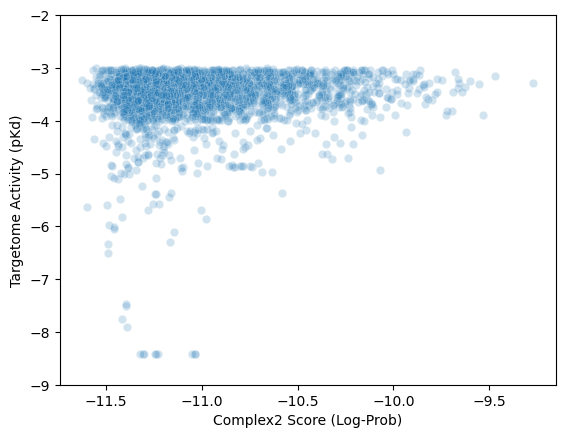

In [131]:
plt.figure() 
sbn.scatterplot(x='score_mean', y='pKd', data=preds, alpha=0.2) 
plt.xlabel('Complex2 Score (Log-Prob)')
plt.ylabel('Targetome Activity (pKd)')
plt.ylim(-9,-2)
plt.show()

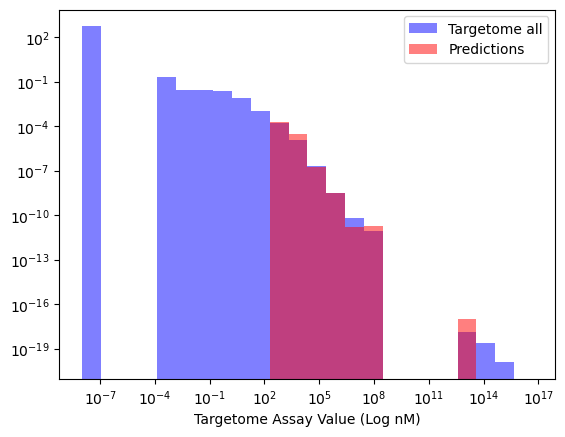

In [109]:
_bins = np.logspace(np.log10(targetome.assay_value.min()), np.log10(targetome.assay_value.max()), 25)

plt.figure()
plt.hist(targetome.assay_value, bins=_bins, density=True, color='blue', alpha=0.5, label='Targetome all')
plt.hist(preds.assay_value, bins=_bins, density=True, color='red', alpha=0.5, label='Predictions')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Targetome Assay Value (Log nM)')
plt.show()


In [72]:
preds[lambda x: x.assay_value.isna()].sort_values(by='fnr_est_mean', ascending=False).head(10)[['inhibitor', 'gene_symbol_x', 'uniprot_id']].style.hide()

inhibitor,gene_symbol_x,uniprot_id
Penfluridol,ADRA1A,P35348
Kw-2449,STK3,Q13188
R-406,MAP4K5,Q9Y4K4
Ast-487,EPHB6,O15197
R-406,MAP4K4,O95819
Sertindole,HTR2B,P41595
R-406,MINK1,Q8N4C8
Zotiraciclib,CDK4,P11802
Ponatinib,FLT4,P35916
Dovitinib,PLK4,O00444


In [49]:
preds[lambda x: x.assay_value.isna()].shape[0]

6719

In [50]:
preds.shape[0]

9177